In [ ]:
import jax.numpy as jnp
import jax

from optimizers.gd import GradientDescentState, gradient_descent_step

from optimizers.mrcg import MRCGState, mrcg_step

import matplotlib.pyplot as plt
from model_zoo import rosenbrock_loss, beale_loss

## Model Definition

In [2]:
initial_params = jnp.array([1.0, 2.0, 3.0])

def model(params, x):
    return x[:, 0] **2 * params[0] + x[:, 1] * params[1] + x[:, 2] * params[2]

def loss(y_pred, y_true):
    return jnp.mean((y_pred - y_true) ** 2)
x = jnp.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
y_true = jnp.array([[1.0], [2.0]])

def loss_at_params(params):
    y_pred = model(params, x)
    return loss(y_pred, y_true)


In [3]:
def harder_model(params, x):
    return (
        jnp.sin(x[:, 0] * params[0]) +
        jnp.exp(-x[:, 1] * params[1]) +
        (x[:, 2] ** 2) * params[2] * jnp.sin(params[2])
    )

x = jnp.array([
        [1.0, 2.0, 3.0],
        [1.0, 5.0, -2.0],
        [0.0, 14.0, 3.0],
        [3.0, 2.0, 8.0]
        ])

## Optimizers Comparison

In [4]:
def iterate_alg(max_iters, initial_state, step_fn, verbose=False) -> list:
    losses = []
    state = initial_state
    for i in range(max_iters):
        loss = state.loss_at_params(state.params)
        losses.append(loss)

        state = step_fn(state)
        if verbose:
            print(f"Iteration {i}: Loss = {loss} Params = {state.params}")
    return losses

Iteration 0: Loss = 14379.93359375 Params = [7.56675   1.7054996]
Iteration 1: Loss = 2023.30810546875 Params = [5.6200523  0.11218679]
Iteration 2: Loss = 640.803466796875 Params = [ 4.4676557  -0.23218861]
Iteration 3: Loss = 340.7772216796875 Params = [ 3.6387534 -0.2608936]
Iteration 4: Loss = 214.75054931640625 Params = [ 2.988881   -0.21748346]
Iteration 5: Loss = 142.0692138671875 Params = [ 2.4632218  -0.16416897]
Iteration 6: Loss = 95.42294311523438 Params = [ 2.0335746  -0.11572078]
Iteration 7: Loss = 64.45588684082031 Params = [ 1.6812094  -0.07469674]
Iteration 8: Loss = 43.676544189453125 Params = [ 1.3919091  -0.04067439]
Iteration 9: Loss = 29.686542510986328 Params = [ 1.1543032  -0.01264157]
Iteration 10: Loss = 20.25835418701172 Params = [0.95913243 0.01040839]
Iteration 11: Loss = 13.903212547302246 Params = [0.7988124  0.02934868]
Iteration 12: Loss = 9.619842529296875 Params = [0.6671184  0.04490871]
Iteration 13: Loss = 6.733431816101074 Params = [0.5589387 0.05

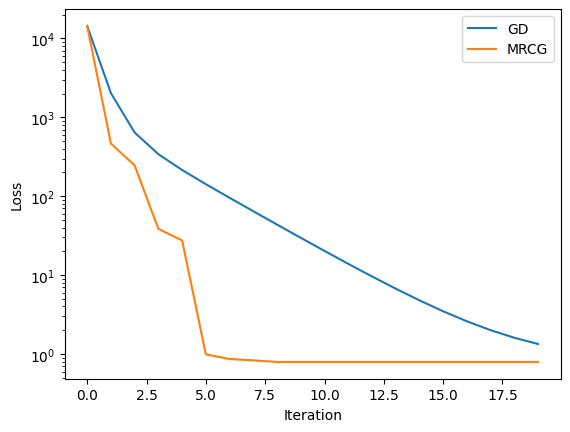

In [8]:
def plot_alg_comparison(ro, initial_params, max_iters=20):
    gd_losses = iterate_alg(
        max_iters,
        GradientDescentState(
            initial_params,
            loss_at_params,
            0.005
        ),
        gradient_descent_step,
        verbose=True
    )


    mrcg_losses = iterate_alg(
        max_iters,
        MRCGState(initial_params, loss_at_params),
        mrcg_step,
        verbose=True
    )
    plt.plot(gd_losses, label='GD')
    plt.plot(mrcg_losses, label='MRCG')
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')

plot_alg_comparison(rosenbrock_loss, jnp.array([12, 8.1]), max_iters=20)

Iteration 0: Loss = 14379.93359375 Params = [7.56675   1.7054996]
Iteration 1: Loss = 2023.30810546875 Params = [5.6200523  0.11218679]
Iteration 2: Loss = 640.803466796875 Params = [ 4.4676557  -0.23218861]
Iteration 3: Loss = 340.7772216796875 Params = [ 3.6387534 -0.2608936]
Iteration 4: Loss = 214.75054931640625 Params = [ 2.988881   -0.21748346]
Iteration 5: Loss = 142.0692138671875 Params = [ 2.4632218  -0.16416897]
Iteration 6: Loss = 95.42294311523438 Params = [ 2.0335746  -0.11572078]
Iteration 7: Loss = 64.45588684082031 Params = [ 1.6812094  -0.07469674]
Iteration 8: Loss = 43.676544189453125 Params = [ 1.3919091  -0.04067439]
Iteration 9: Loss = 29.686542510986328 Params = [ 1.1543032  -0.01264157]
Iteration 10: Loss = 20.25835418701172 Params = [0.95913243 0.01040839]
Iteration 11: Loss = 13.903212547302246 Params = [0.7988124  0.02934868]
Iteration 12: Loss = 9.619842529296875 Params = [0.6671184  0.04490871]
Iteration 13: Loss = 6.733431816101074 Params = [0.5589387 0.05

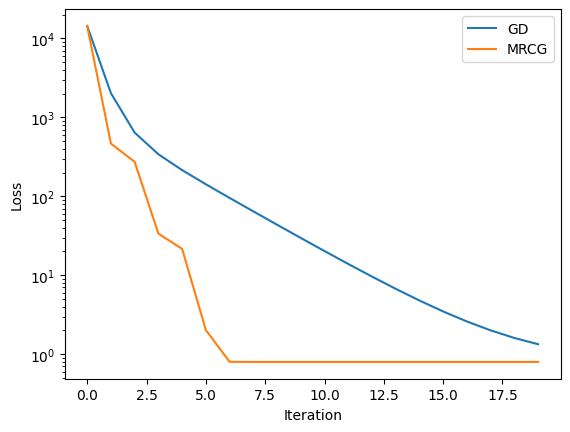

In [9]:
plot_alg_comparison(beale_loss, jnp.array([12, 8.1]), max_iters=20)